In [336]:
import numpy as np
import cantera as ct
import matplotlib.pyplot as plt

In [337]:
# import the model for gas-Fe interface and adjacent gas phase
cat = ct.Interface('FeSiO2_NOMC.yaml','Fe_surf')
gas = cat.adjacent['gas']

In [338]:
# Set the initial conditions
T0 = 1373.15 # K
p0 = ct.one_atm # atm
gas.TPX = T0, p0, "CH4: 0.9, N2: 0.1"
cat.TP = T0, p0
D = 0.004 # diameter of the tube [m]
Ac = np.pi * D**2 / 4 # corss section of the tube [m2]
w_cat = 0.82 # weight of catalyst [gcat]
GHSV = 0.002016 # m3/gcat/hr
u0 = GHSV * w_cat /3600 / Ac # [m/s]

In [339]:
# Set the Reactor conditions
reactor = ct.FlowReactor(gas)
reactor.area = Ac
reactor.mass_flow_rate = gas.density * u0 * Ac
reactor.energy_enabled = False

rsurf = ct.ReactorSurface(cat, reactor)
net = ct.ReactorNet([reactor])
soln = ct.SolutionArray(gas, extra=['x', 'surf_coverages'])

print(Ac)

1.2566370614359172e-05


In [340]:
# Integrate the reactor network
while net.distance < 0.06:
    print(net.distance, rsurf.coverages)
    net.step()
    wdot = rsurf.kinetics.net_production_rates
    soln.append(TDY=reactor.thermo.TDY,
                x=net.distance,
                surf_coverages=rsurf.coverages
                )

0.0 [1. 0. 0. 0. 0.]
1e-14 [2.28260716e-04 5.90059929e-01 2.22529392e-04 3.88908951e-08
 4.09489242e-01]
2e-14 [2.28260716e-04 5.90059929e-01 2.22529392e-04 3.88908951e-08
 4.09489242e-01]
4e-14 [2.28260716e-04 5.90059929e-01 2.22529392e-04 3.88908951e-08
 4.09489242e-01]
8e-14 [2.28260716e-04 5.90059929e-01 2.22529392e-04 3.88908951e-08
 4.09489242e-01]
1.6e-13 [2.28260716e-04 5.90059929e-01 2.22529392e-04 3.88908951e-08
 4.09489242e-01]
3.2e-13 [2.28260716e-04 5.90059929e-01 2.22529392e-04 3.88908951e-08
 4.09489242e-01]
6.4e-13 [2.28260716e-04 5.90059929e-01 2.22529392e-04 3.88908951e-08
 4.09489242e-01]
1.28e-12 [2.28260716e-04 5.90059929e-01 2.22529392e-04 3.88908951e-08
 4.09489242e-01]
2.56e-12 [2.28260716e-04 5.90059929e-01 2.22529392e-04 3.88908951e-08
 4.09489242e-01]
5.12e-12 [2.28260716e-04 5.90059929e-01 2.22529392e-04 3.88908951e-08
 4.09489242e-01]
1.024e-11 [2.28260716e-04 5.90059929e-01 2.22529392e-04 3.88908951e-08
 4.09489242e-01]
2.048e-11 [2.28260716e-04 5.90059929

[Text(0.5, 0, 'Distance (cm)'),
 Text(0, 0.5, 'Site Fraction'),
 Text(0.5, 1.0, 'Surface species')]

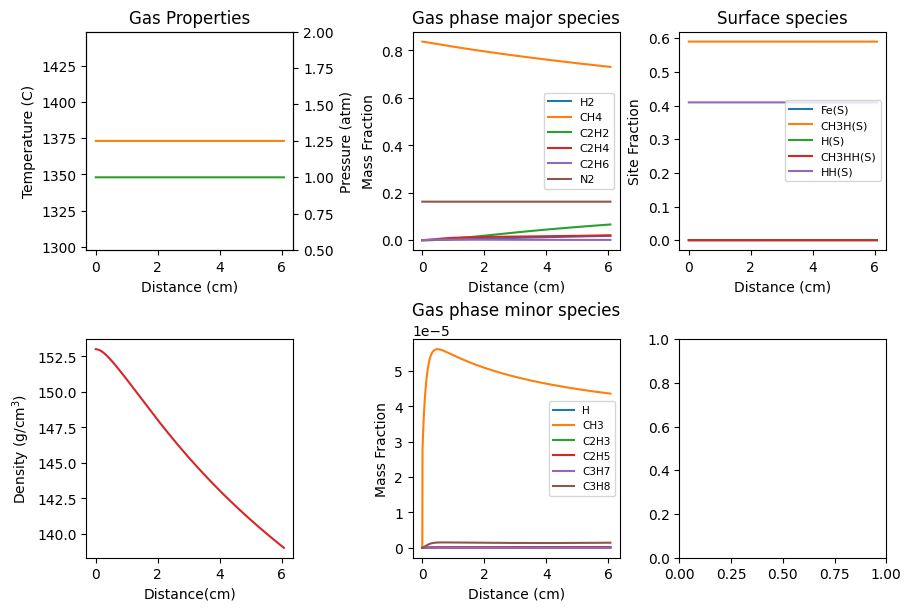

In [341]:
# plot the results
plt.rcParams['figure.constrained_layout.use'] = True
f, ax = plt.subplots(2, 3, figsize=(9,6))

# plot the temperature profile along the flow direction
ax[0,0].plot(soln.x*100, soln.T[:], color='C1')
ax[0,0].set(xlabel='Distance (cm)', ylabel='Temperature (C)', title='Gas Properties')

# plot the pressure of gas along the flow direction
ax_p = ax[0,0].twinx()
ax_p.plot(soln.x*100, soln.P/101325, color='C2')
ax_p.set(ylabel='Pressure (atm)',ylim = (0.5,2))

# plotgas density along the flow direction
ax[1,0].plot(soln.x*100, soln.density*1000, color='C3', label='density')
ax[1,0].set(xlabel='Distance(cm)',ylabel=r'Density ($\mathregular{g/cm^3}$)')

# plot major and minor gas species separately
minor_idx = []
major_idx = []
for i, name in enumerate(gas.species_names):
    mean = np.mean(soln(name).Y)
    if mean >= 0.001:
        major_idx.append(i)
    elif mean >= 1e-10:
        minor_idx.append(i)

# plot major gas species along the flow direction
for j in major_idx:
    ax[0, 1].plot(soln.x*100, soln.Y[:,j], label=gas.species_name(j))
ax[0, 1].legend(fontsize=8, loc='best')
ax[0, 1].set(xlabel='Distance (cm)', ylabel='Mass Fraction',
             title='Gas phase major species')

# plot minor gas species along the flow direction
for k, i in enumerate(minor_idx):
    style = '-' if k < 10 else '--'
    ax[1, 1].plot(soln.x*100, soln.Y[:,i], label=gas.species_name(i), linestyle=style)
ax[1, 1].legend(fontsize=7.5, loc='best')
ax[1, 1].set(xlabel='Distance (cm)', ylabel='Mass Fraction',
             title='Gas phase minor species')

# plot the site fraction of the surface species along the flow direction
for i, name in enumerate(cat.species_names):
    ax[0, 2].plot(soln.x*100, soln.surf_coverages[:, i], label=name)
ax[0, 2].legend(fontsize=8)
ax[0, 2].set(xlabel='Distance (cm)', ylabel='Site Fraction', title='Surface species')

In [342]:
print(soln('CH4').Y[-1][0])
print(soln.density[0])
print(u0)

0.7307473143541516
0.1530045079995166
0.03654197493389917
